# 2 Partie2: Segmentation des cellules basophiles

 ## 2.1 Contexte et enjeux

 Les basophiles sont un type de globules blancs appartenant à la famille des
 leucocytes. Ils jouent un rôle clé dans le système immunitaire, notamment dans
 les réactions allergiques et inflammatoires. Bien que peu nombreux dans le sang (moins de 1 % des leucocytes), ils sont essentiels pour la défense de l’organisme contre certaines infections et participent à la libération de substances comme l’histamine.

 Dans le domaine de l’analyse d’images biomédicales, la segmentation des
 basophiles est une étape importante pour plusieurs raisons :
 - Aide au diagnostic médical : Une variation anormale de leur nombre
 ou de leur morphologie peut indiquer des pathologies comme des allergies
 sévères ou certaines maladies du sang.

 - Automatisation de l’analyse sanguine : Les laboratoires utilisent des
 systèmes de vision par ordinateur pour identifier et compter les cellules de
 manière plus rapide et fiable que l’analyse humaine.

 - Etude de la réponse immunitaire : En séparant précisément ces cellules du reste de l’image (autres cellules sanguines, fond de lames de microscope), on peut mieux comprendre leurs interactions et leur fonctionnement.

 L’objectif de cette partie du TP est d’explorer différentes techniques de seg
mentation d’images pour isoler les cellules basophiles à partir d’images acquises au microscope

 ## 2.2 Travail demandé

 Cette partie n’est pas guidée et vous demande donc une démarche de réflexion et de recherche. Les images fournies sont bruitées, ce qui complique leur analyse.

 L’objectif est de :

 - Proposer une méthode pour compter automatiquement les cellules basophiles dans l’image.

 - Justifier votre approche et vos choix de manière détaillée.

 Vous êtes libres d’explorer différentes techniques de traitement d’image pour
 atteindre cet objectif. Un rapport synthétique expliquant vos étapes, vos résultats et vos décisions sera attendu en fin de TP. Toute démarche de réflexion valide et expliquée clairement sera prise en compte, un code fonctionnel est un plus.

## Preprocessing

Nous allons commencer par importer les bibliothèques nécessaires au déroulement de ce projet.

In [292]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

Pour commencer, nous allons importer les quatre images qui nous ont été fournies; puis nous allons créer une fonction nous permettant de toutes les afficher en même temps de manière lisible.

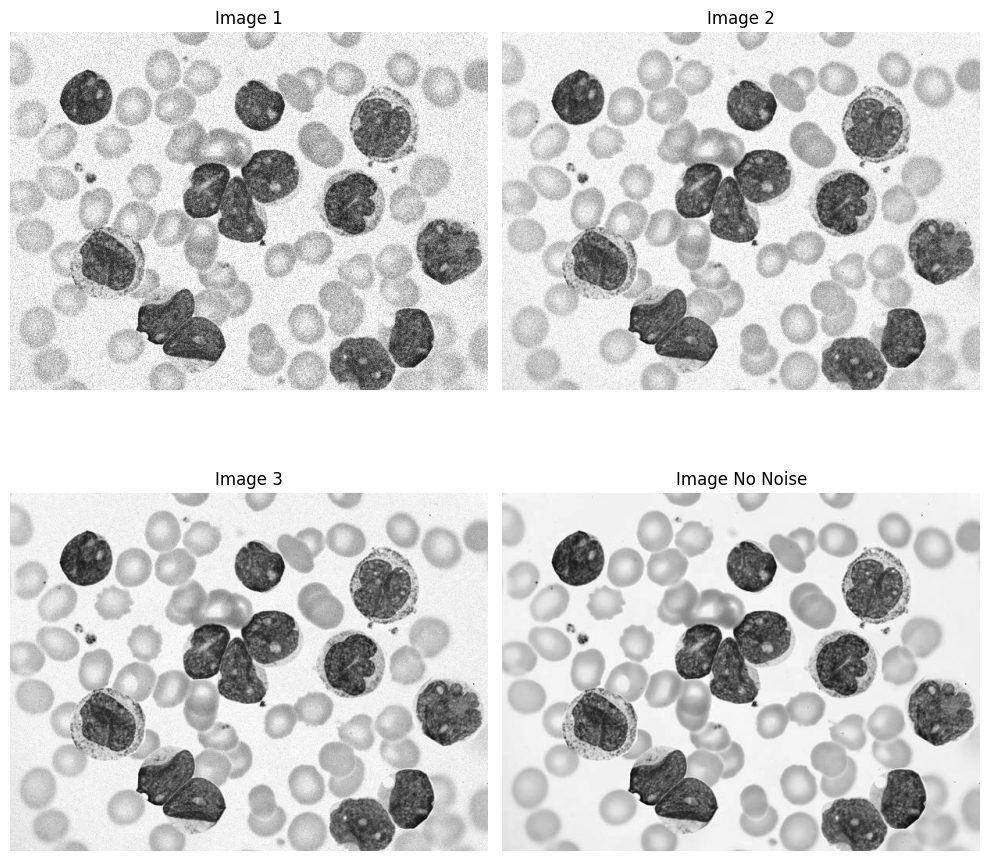

In [293]:
path = os.getcwd()

img1 = cv2.imread(f'{path}/imageonline-co-noisedimage.png', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread(f'{path}/imageonline-co-noisedimage1.png', cv2.IMREAD_GRAYSCALE)
img3 = cv2.imread(f'{path}/imageonline-co-noisedimage2.png', cv2.IMREAD_GRAYSCALE)
img_nonoise = cv2.imread(f'{path}/leucC3A9mie-cellules.png', cv2.IMREAD_GRAYSCALE)

def show_four_images(img1, img2, img3, img4):
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))

    axes[0, 0].imshow(img1, cmap="gray")
    axes[0, 0].set_title("Image 1")

    axes[0, 1].imshow(img2, cmap="gray")
    axes[0, 1].set_title("Image 2")

    axes[1, 0].imshow(img3, cmap="gray")
    axes[1, 0].set_title("Image 3")

    axes[1, 1].imshow(img4, cmap="gray")
    axes[1, 1].set_title("Image No Noise")

    for ax in axes.flat:
        ax.axis("off")

    plt.tight_layout()
    plt.show()

show_four_images(img1, img2, img3, img_nonoise)

## Denoising

Pour diminuer le bruit, nous allons utiliser 3 fonctions différentes : le flou gaussien, le filtre median, et les non-local means. Les images étant plus ou moins bruitées, il sera aisé de détecter quelle fonction est la plus efficace dans notre cas.

### Gaussian Blur

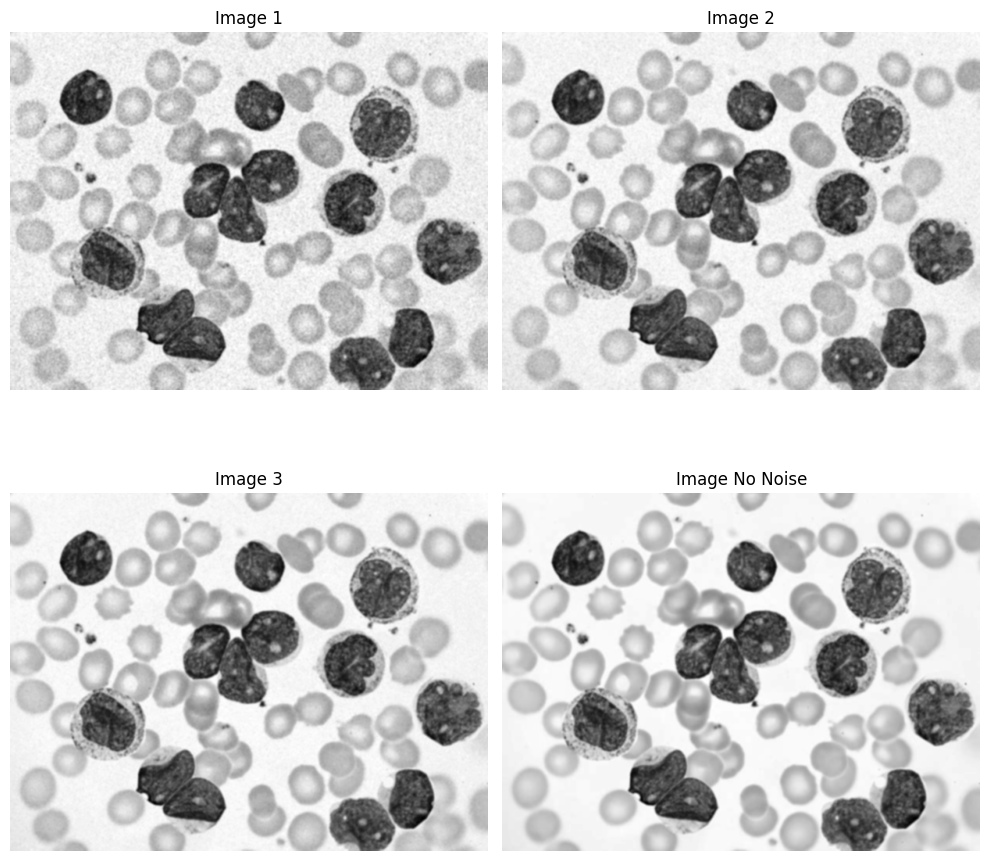

In [294]:
kernel_size = (5, 5)

blurred_image_G_1 = cv2.GaussianBlur(img1, kernel_size, 0)
blurred_image_G_2 = cv2.GaussianBlur(img2, kernel_size, 0)
blurred_image_G_3 = cv2.GaussianBlur(img3, kernel_size, 0)
blurred_image_G_nonoise = cv2.GaussianBlur(img_nonoise, kernel_size, 0)


show_four_images(blurred_image_G_1, blurred_image_G_2, blurred_image_G_3, blurred_image_G_nonoise)

### Median Filter 

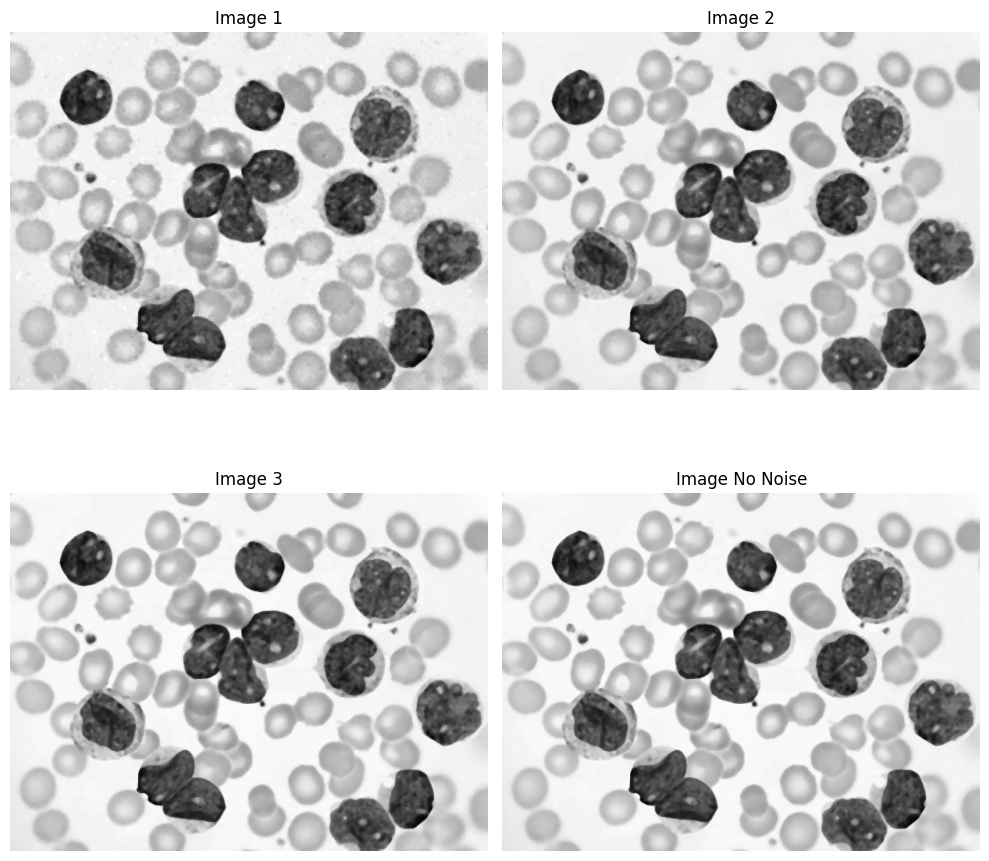

In [295]:
kernel_size = 5

blurred_image_MB_1 = cv2.medianBlur(img1, kernel_size, 0)
blurred_image_MB_2 = cv2.medianBlur(img2, kernel_size, 0)
blurred_image_MB_3 = cv2.medianBlur(img3, kernel_size, 0)
blurred_image_MB_NoNoise = cv2.medianBlur(img_nonoise, kernel_size, 0)

show_four_images(blurred_image_MB_1, blurred_image_MB_2, blurred_image_MB_3, blurred_image_MB_NoNoise)

### Non-Local Means

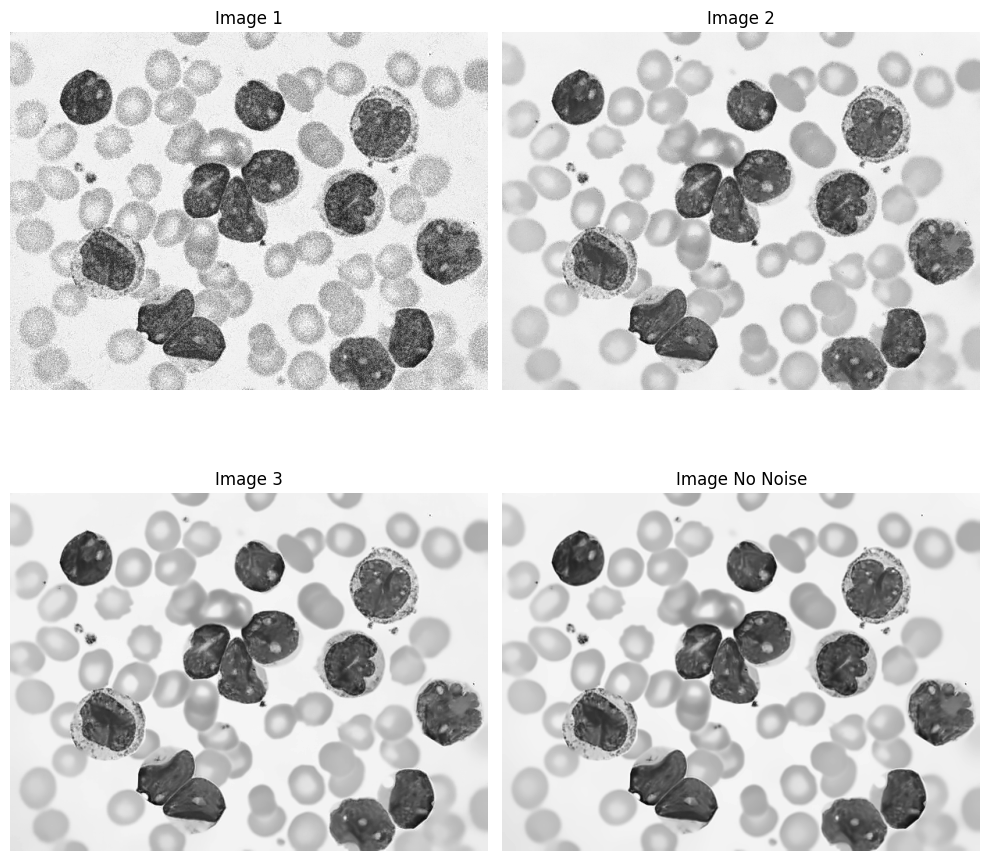

In [296]:
blurred_image_nlm_1 = cv2.fastNlMeansDenoising(img1, None, 10, 7, 21)
blurred_image_nlm_2 = cv2.fastNlMeansDenoising(img2, None, 10, 7, 21)
blurred_image_nlm_3 = cv2.fastNlMeansDenoising(img3, None, 10, 7, 21)
blurred_image_nlm_NoNoise = cv2.fastNlMeansDenoising(img_nonoise, None, 10, 7, 21)

show_four_images(blurred_image_nlm_1, blurred_image_nlm_2, blurred_image_nlm_3, blurred_image_nlm_NoNoise)

On peut observer après l'utilisation de ces trois filtres que le plus efficace pour diminuer le bruit et séparer les cellules semble être le Median Filter. Nous allons donc utiliser les images filtrées par ce dernier pour les opérations suivantes.

### Seuillage

Nous allons maintenant procéder à un seuillage afin de diminuer à nouveau le bruit et séparer les cellules. Le seuillage d'Otsu semble approprié dans notre cas, et nous allons le coupler à un seuillage inversé afin de rendre les opérations morphologiques plus efficaces par la suite.

#### Méthode d'Otsu

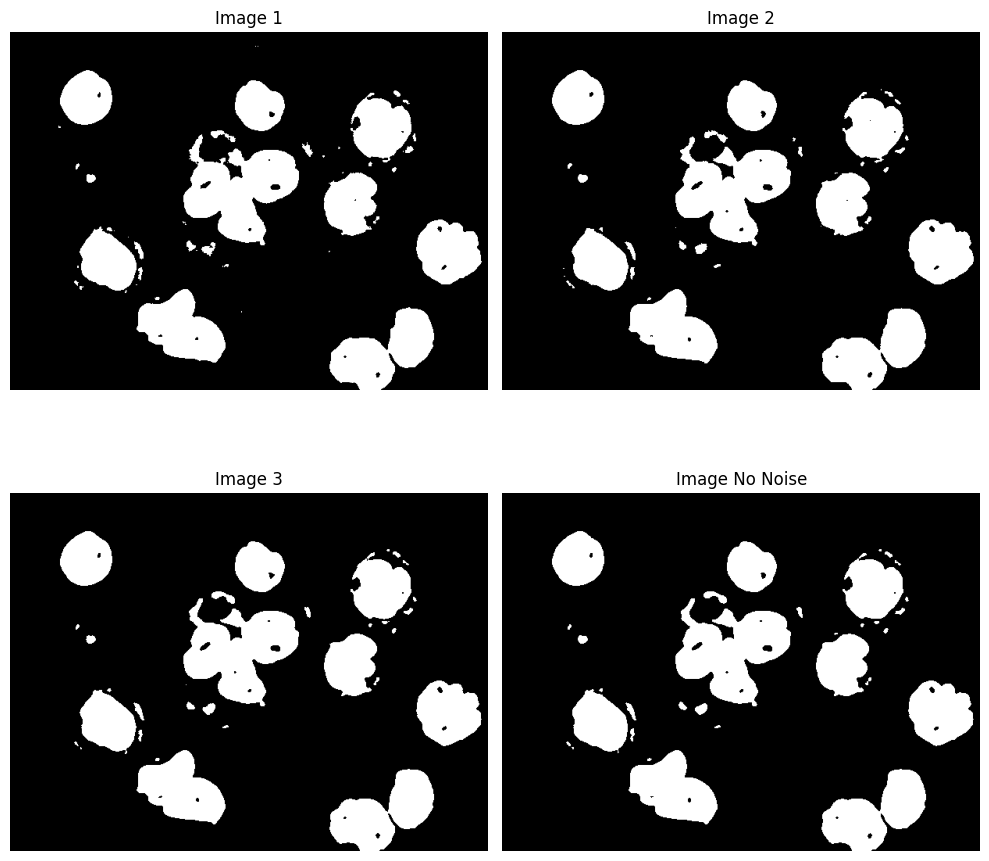

In [297]:
def compute_histogram(image):
    # Compute histogram manually
    histogram = np.zeros(256, dtype=int)  # Initialize array for 256 intensity values

    # Count pixel occurrences
    for pixel_value in image.flatten():  # Flatten the image to a 1D array
        histogram[pixel_value] += 1
    return histogram

def otsu_threshold(image):
    # Calcul de l'histogramme de l'image
    hist = compute_histogram(image)
    
    # Normalisation de l'histogramme pour obtenir les probabilités de chaque pixel
    total_pixels = image.size
    probas = hist / total_pixels # probabilité d'aparition pour chaque pixel
    
    # Calcul de la moyenne globale de l'image
    global_mean = np.mean(image)
    
    # Initialisation des variables pour le calcul du seuil optimal
    best_threshold = 0
    max_between_class_variance = 0
    
    # Variables pour stocker les informations sur les classes
    w0 = 0  # Poids de la première classe (pixels <= T)
    w1 = 0  # Poids de la deuxième classe (pixels > T)
    mean0 = 0  # Moyenne de la première classe
    mean1 = 0  # Moyenne de la deuxième classe

    for t in range(256):
        w0 += probas[t]  # Update weight of class 1
        if w0 == 0 or w0 == 1:  # Avoid division by zero
            continue
        w1 = 1 - w0  # Weight of class 2
        
        mean0 += t * probas[t]  # Update mean of class 1
        mean1 = (global_mean - mean0) / w1  # Compute mean of class 2
        
        # Compute between-class variance
        between_class_variance = w0 * w1 * (mean0 / w0 - mean1) ** 2

        # Check if the variance is maximized
        if between_class_variance > max_between_class_variance:
            max_between_class_variance = between_class_variance
            best_threshold = t
    
    # Apply threshold to create binary image
    binary_image = np.where(image > best_threshold, 0, 255).astype(np.uint8)
    
    return best_threshold, binary_image

best_threshold, img1_otsu = otsu_threshold(blurred_image_MB_1) 
best_threshold, img2_otsu = otsu_threshold(blurred_image_MB_2)
best_threshold, img3_otsu = otsu_threshold(blurred_image_MB_3)
best_threshold, img_nonoise_otsu = otsu_threshold(blurred_image_MB_NoNoise)

show_four_images(img1_otsu, img2_otsu, img3_otsu, img_nonoise_otsu)


### Operations Morphologiques : ouverture

Nous allons utiliser la fonction morphologyEx du package opencv. Nous avons choisi d'effectuer une ouverture car cette opération se compose d'une érosion suivie d'une dilatation : l'érosion permettra de supprimer le bruit restant de l'image et de mieux séparer les objets collés, et la dilatation permettra d'arrondir les angles. De multiples itérations peuvent s'avérer nécessaires.

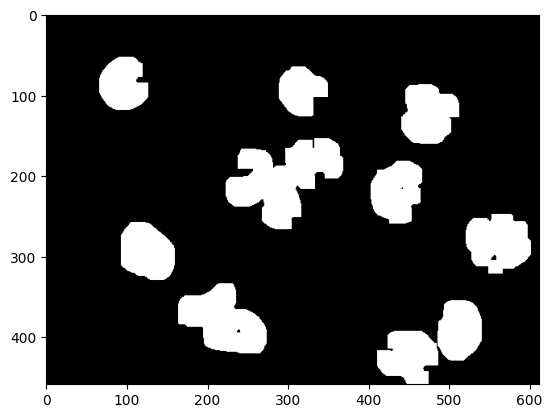

In [298]:
kernel = np.ones((5, 5), np.uint8)  # Increase kernel size
img1_ouvert = cv2.morphologyEx(img1_otsu, cv2.MORPH_OPEN, kernel, iterations=4)

plt.imshow(img1_ouvert, cmap='gray')

### Détection des contours

Nous allons utiliser la fonction findContours d'openCV afin de détecter les contours des différentes formes de notre image. Nous allons également récupérer les centroids de chaque forme afin de montrer plus clairement ce qui est considéré comme une forme, et voir comment en améliorer la précision.

In [ ]:

from scipy.spatial import distance

contours, _ = cv2.findContours(img1_ouvert, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Function to compute the centroid of a contour
def get_centroid(cnt):
    M = cv2.moments(cnt)
    if M["m00"] == 0:
        return None
    cx = int(M["m10"] / M["m00"])
    cy = int(M["m01"] / M["m00"])
    return (cx, cy)

# Compute centroids for all contours
centroids = [get_centroid(cnt) for cnt in contours if get_centroid(cnt) is not None]

# Set minimum distance threshold
min_distance = 20 

# Filter contours based on centroid distance
filtered_contours = []
for i, c1 in enumerate(centroids):
    keep = True
    for j, c2 in enumerate(centroids):
        if i != j and distance.euclidean(c1, c2) < min_distance:
            keep = False
            break
    if keep:
        filtered_contours.append(contours[i])


print(f"Number of detected edges: {len(filtered_contours)}")

# Draw filtered contours
output = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
cv2.drawContours(output, filtered_contours, -1, (0, 255, 0), 2)

# Draw centroids
for c in centroids:
    cv2.circle(output, c, 5, (0, 0, 255), -1)  # Red dot at centroid 
# Show results
cv2.imshow("Filtered Contours by Distance and Centroids", output)
cv2.waitKey(0)
cv2.destroyAllWindows()

Number of detected edges: 10


# Conclusion

Le résultat final est que 10 formes ont été détectées. Graphiquement, on peut observer à l'aide de l'output final que le bruit a été efficacement réduit, mais que les cellules qui apparaissaient collées sur l'image originale n'ont pas pu être séparées, amenant le total de cellules détectées à 10 au lieu de 13. Cependant, on peut constater que le programme parvient à détecter efficacement les cellules isolées et à en donner les centroïdes efficacement.

Comme les images fournies sont identiques, il n'est pas possible actuellement de savoir si ce programme est efficace dans la détection des cellules basophiles sur d'autres photographies.

Des pistes d'amélioration incluent l'utilisation de la fonction Watershed afin de séparer plus efficacement les contours des formes proches, ainsi que des paramètres d'opérations morphologiques plus specifiques pour mieux séparer les cellules proches. Un seuillage plus sensible pourrait également être envisagé afin de mieux détecter les différences de luminosité subtiles entre les différentes cellules ayant une forte proximité. Il serait aussi possible de calculer l'aire moyenne d'une cellule et de diviser les objets paraissant plus gros afin de trouver le nombre de cellules présentes lorsqu'une très grosse cellule est détectée.